# Optotagged FTCs
here we try to create a native python tuning plot, and then try to determine differencese between putative
inhibitory interneurons and pyramidal cells defined by optotagging


In [1]:
import itertools as itt
import pathlib as pl
import joblib as jl
from configparser import ConfigParser

import numpy as np
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl

from IPython.display import display

from nems_lbhb.baphy_experiment import  BAPHYExperiment
from nems.epoch import epoch_names_matching
import nems.db as nd
from src.visualization.fancy_plots import  subplots_sqr
from src.metrics.reliability import signal_reliability
from src.root_path import config_path

/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:81: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-10-25 151913.log
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


#### Loads FTC data
right now form a single file
to do, load based on DF querries for neruons

In [140]:

plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))



# set general parameters for loading and plotting
parmfile = '/auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m'
rasterfs = 1000 # in samps per sec
options ={'recache': False, 'resp': True, 'rasterfs': rasterfs, 'stim':False}


In [141]:
def get_rec(parmfile, rasterfs=1000):
    options ={'recache': False, 'resp': True, 'rasterfs': rasterfs, 'stim':False}
    manager = BAPHYExperiment(parmfile=parmfile)
    rec = manager.get_recording(**options)
    return rec


rec = get_rec(parmfile)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC018a/TNC018a_74419e843e6e9c89ab9a6c77ae310f3e6cc59026.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


#### works with a whole site at a time
get the response of a neuron to all different tones, sorts the dictionary of tone responses
into an array of shape Repetitions x Neurons x ToneFreq x Time

then parses the important parts of the response, I.E Onset (50ms) Ofsset (50ms) and full duration
(100ms)

mean across repetitions and time (for the time chunck selected, e.g. onset) standard error of the mean over the same numbers



In [174]:
# once you have the recording extract the raw data

def get_tuning_curves(rec, part='all', onset_dur=0.05, offset_dur=0.05, normalize=None, smooth=None):
    rasterfs = rec.meta['rasterfs']
    epochs = rec.epochs
    tone_eps = epoch_names_matching(epochs,'\ASTIM_\d*\Z')
    tone_eps.sort(key= lambda x: int(x.split('_')[1]))
    frequencies = np.asarray([int(t.split('_')[1]) for t in tone_eps])

    resp = rec['resp'].rasterize()
    raster = resp.extract_epochs(tone_eps)

    R, N, T = raster[tone_eps[0]].shape # repetitions, Neurons, time
    S = len(tone_eps)
    site_raster = np.empty((R, N, S, T))

    for ii, key in enumerate(tone_eps):
        site_raster[:, :, ii, :] = raster[key]

    # we need the pre stim silence and sound duration to get different parts of the response parsed out
    PreStimSilence = resp.extract_epoch('PreStimSilence')
    pre_stim_bins = PreStimSilence.shape[-1]
    post_stim_bins = resp.extract_epoch('PostStimSilence').shape[-1]

    if part == 'all':
        raster = site_raster[..., pre_stim_bins :T-post_stim_bins]
    elif part == 'onset':
        raster = site_raster[..., pre_stim_bins : pre_stim_bins + int(onset_dur * rasterfs)]
    elif part == 'offset':
        raster = site_raster[..., T-post_stim_bins : T - post_stim_bins + int(offset_dur * rasterfs)]
    else:
        raise  ValueError

    if normalize == 'zscore':
        raster = (raster - PreStimSilence.mean(axis=(0,-1))[None,:,None,None])\
                 / PreStimSilence.std(axis=(0,-1))[None, :, None, None]
        tuning_curves = raster.mean(axis=(0,-1))
        SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T)
        spont_rates = np.zeros(N)

    elif normalize == 'subdiv':
        spont_rates = PreStimSilence.mean(axis=(0,-1))[:, None]
        tuning_curves = raster.mean(axis=(0,-1))
        max_resp =  tuning_curves.max(axis=1)[:, None]
        tuning_curves = (tuning_curves - spont_rates) / max_resp
        SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T) / max_resp
        spont_rates = np.zeros(N)

    elif normalize == None:
        tuning_curves = raster.mean(axis=(0,-1)) * rasterfs
        SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T) * rasterfs
        spont_rates = PreStimSilence.mean(axis=(0, -1)) * rasterfs

    else:
        raise ValueError(f'unknown normalization {normalize}')

    if smooth != None:
        tuning_curves = gaussian_filter1d(tuning_curves, sigma=smooth)


    return tuning_curves, SEMs, spont_rates, frequencies


tuning_curves, SEMs, spont_rates, frequencies = get_tuning_curves(rec, normalize='subdiv')


<ipython-input-174-c457ee380589>:45: RuntimeWarning: divide by zero encountered in true_divide
  tuning_curves = (tuning_curves - spont_rates) / max_resp
<ipython-input-174-c457ee380589>:46: RuntimeWarning: invalid value encountered in true_divide
  SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T) / max_resp


#### Plots one example cell
the quality of the plot has been confirmed by comparing with its baphy remote equivalent
there are minor discrepancies but nothing to be worried about.

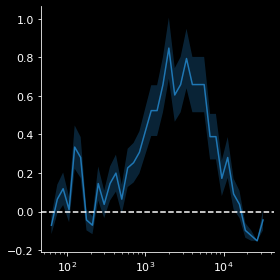

In [175]:
def plot_tuning_curve(tuning_curve, SEM, spont_rate, frequencies, ax=None, logscale=True, **kwargs):

    lower = tuning_curve - SEM
    upper = tuning_curve + SEM

    if ax == None:
        fig, ax = plt.subplots()

    _ = ax.plot(frequencies, tuning_curve, **kwargs)
    _ = ax.fill_between(frequencies, lower, upper, alpha=0.3, **kwargs)
    _ = ax.axhline(spont_rate, linestyle='--', *kwargs)
    if logscale:
        ax.set_xscale('log')
    return ax



# ploting
selected_cells = [rec['resp'].chans[-1]]
fig, axes = subplots_sqr(len(selected_cells), sharex=True, sharey=False)

for ax, cellid in zip(axes, selected_cells):
    cell_idx = rec['resp'].chans.index(cellid)
    _ = plot_tuning_curve(tuning_curves[cell_idx,:], SEMs[cell_idx,:], spont_rates[cell_idx], frequencies, ax=ax)

fig.tight_layout()


### compares normalized vs non normalized tuning curve

<ipython-input-174-c457ee380589>:45: RuntimeWarning: divide by zero encountered in true_divide
  tuning_curves = (tuning_curves - spont_rates) / max_resp
<ipython-input-174-c457ee380589>:46: RuntimeWarning: invalid value encountered in true_divide
  SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T) / max_resp


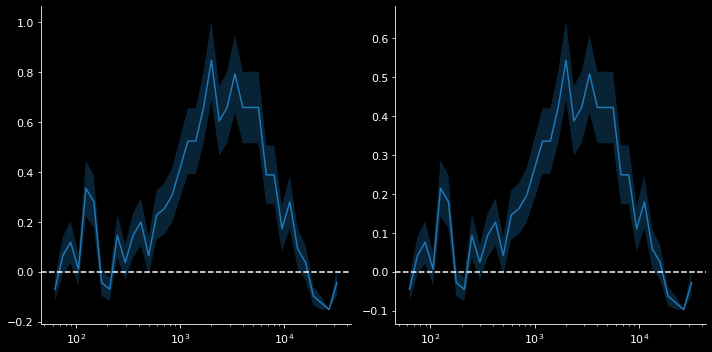

In [182]:
cell_idx = -1

fig, axes = plt.subplots(1,2, figsize=(10,5))

tuning_curves, SEMs, spont_rates, frequencies = get_tuning_curves(rec, normalize='subdiv')
_ = plot_tuning_curve(tuning_curves[cell_idx,:], SEMs[cell_idx,:], spont_rates[cell_idx], frequencies, ax=axes[0])

tuning_curves, SEMs, spont_rates, frequencies = get_tuning_curves(rec, normalize='zscore')
_ = plot_tuning_curve(tuning_curves[cell_idx,:], SEMs[cell_idx,:], spont_rates[cell_idx], frequencies, ax=axes[1])



# now to quantify
### first define two methods to either re-label frequencies or center and stack tuning curves

In [183]:
def zero_at_bf(tuning_curves, frequencies):
    """
    creates a new version of frequencies relative to the tuning max, i.e. best frequencies, and with values in octaves
    relative to this best frequency
    """
    N, S = tuning_curves.shape
    relative_freqs = np.empty((N, S))

    for cc, curve in enumerate(tuning_curves):
        bf_idx = np.argmax(curve)
        relative_freqs[cc,:] = np.log2(frequencies/frequencies[bf_idx])

    return  relative_freqs

relative_freqs = zero_at_bf(tuning_curves, frequencies)
print(f'relative_freqs shape N x F: {relative_freqs.shape}')
def aling_at_bf(tuning_curves, frequencies):
    """
    re stacks the tuning curves in a nan paded array, such that all the best frequencies are aligned
    """
    N, S = tuning_curves.shape
    centered_tuning_curves = np.full((N, S*2), np.nan)
    for cc, curve in enumerate(tuning_curves):
        bf_idx = np.argmax(curve)
        centered_tuning_curves[cc, S-bf_idx: S*2-bf_idx] = curve

    bin_octave_size = np.diff(np.log2(frequencies/frequencies[0])).mean().round(decimals=2)
    common_rel_freqs = np.linspace(S*-bin_octave_size, S*bin_octave_size, S*2, endpoint=False)

    # if there is extra nan padding across al neurons, removes it
    mask = ~np.all(np.isnan(centered_tuning_curves), axis=0)
    centered_tuning_curves = centered_tuning_curves[:, mask]
    common_rel_freqs = common_rel_freqs[mask]

    return centered_tuning_curves, common_rel_freqs

centered_tuning_curves, common_rel_freqs = aling_at_bf(tuning_curves, frequencies)
print(f'centered_tuning_curves shape N x 2F: {centered_tuning_curves.shape}',
      f'commmon_rel_freq shape 2F: {common_rel_freqs.shape}')

relative_freqs shape N x F: (99, 37)
centered_tuning_curves shape N x 2F: (99, 73) commmon_rel_freq shape 2F: (73,)


first plot every tuning curve independently, with a different x axis each time

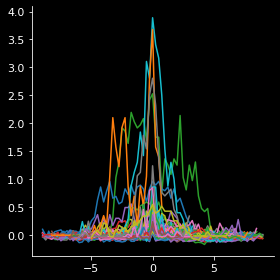

In [184]:
fig, ax = plt.subplots()
for x, curve in zip(relative_freqs, tuning_curves):
    _ = ax.plot(x, curve)


alternatively plot all the pre centered tuning curves and figure out the common x axis

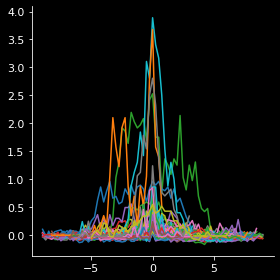

In [185]:
fig, ax = plt.subplots()
_ = ax.plot(common_rel_freqs, centered_tuning_curves.T)

In [11]:
best_neu_idx, _ = np.where(tuning_curves == tuning_curves.max())
best_neu_idx = best_neu_idx[0]
print(f'best neuron index: {best_neu_idx}')

best neuron index: 79


### lets calculate the full width at half maximum
this is a quick measure of the broadness of tuning

In [209]:
def full_width_half_max(tuning_curves, frequencies, spont_rates):
    def _fwhm(tuning_curve, frequencies, spont_rate):
        # calculates the halfmax as the half delta, since many neurons have a high spont rate
        halfmax = (spont_rate + tuning_curve.max())/2
        max_idx = np.argmax(tuning_curve)
        # special cases when bf is on the edge of tuning curve
        if max_idx == 0:
            left_idx = 0
            right_idx = (tuning_curve[max_idx+1:] < halfmax).argmax() + max_idx + 1
        elif max_idx == len(tuning_curve)-1:
            left_idx = max_idx - (tuning_curve[:max_idx][::-1] < halfmax).argmax() - 1
            right_idx = len(tuning_curve)-1
        else:
            # picks the index of the righmost occurrence of the ~ half max to the left of max idx, excluding the max_idx itself
            left_idx = max_idx - (tuning_curve[:max_idx][::-1] < halfmax).argmax() - 1
            # picks the index of the leftmost occurrence of ~ halfmax to the right of max_idx, excluing max_idx itself.
            right_idx = (tuning_curve[max_idx+1:] < halfmax).argmax() + max_idx + 1

        bin_octave_size = np.diff(np.log2(frequencies/frequencies[0])).mean().round(decimals=2)

        fwhm = (right_idx - left_idx) * bin_octave_size

        return fwhm, np.array([left_idx, right_idx])

    FWHM = np.empty(tuning_curves.shape[0])
    widht_idx = np.empty((tuning_curves.shape[0],2))
    for cc, (curve, spont) in enumerate(zip(tuning_curves, spont_rates)):
        FWHM[cc], widht_idx[cc,:] = _fwhm(curve, frequencies, spont)

    return FWHM, widht_idx.astype(int)

# FWHM, widht_idx = full_width_half_max(tuning_curves, frequencies, spont_rates)
# display(widht_idx[best_neu_idx,0])

20

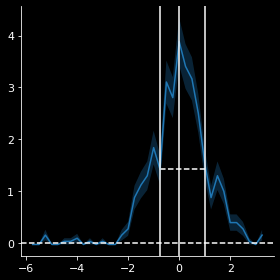

In [210]:
def plot_fwhm(tuning_curve, SEM, spont_rate, frequencies, ax=None, **kwargs):

    FWHM, widht_idx = full_width_half_max(tuning_curve[None,:], frequencies, spont_rate[None])
    frequencies = zero_at_bf(tuning_curve[None,:], frequencies)[0,:]

    ax = plot_tuning_curve(tuning_curve, SEM, spont_rate, frequencies, ax=ax, logscale=False, **kwargs)

    max_idx = np.argmax(tuning_curve[:])
    left_idx, right_idx = widht_idx[0,:]

    ax.axvline(frequencies[max_idx])
    ax.axvline(frequencies[left_idx])
    ax.axvline(frequencies[right_idx])
    ax.hlines(tuning_curve[left_idx], frequencies[left_idx], frequencies[right_idx],
                linestyle='--')
    return ax

_ = plot_fwhm(tuning_curves[best_neu_idx,:], SEMs[best_neu_idx,:], spont_rates[best_neu_idx], frequencies)

### alteratively median and integral based calculations
perhaps with some gaussian fitting.

center sum: 14.761592359491736 full half: 16.47875718498363
half integral: (1,) width_idx: (1, 2)


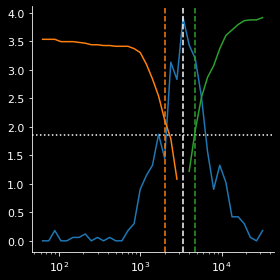

In [290]:
def half_integral(tuning_curves, frequencies, db_plot=False ,**kwargs):
    def _half_int(tuning_curve, frequencies, db_plot):
        tuning_curve = tuning_curve - np.min(tuning_curve)
        max_idx = np.argmax(tuning_curve)
        threshold = np.absolute(tuning_curve).sum() / 4
        # special cases when bf is on the edge of tuning curve
        if max_idx == 0:
            left_idx = 0
            right_abs_cum_sum = np.abs(tuning_curve[max_idx+1:]).cumsum() + np.max(tuning_curve) / 2
            right_idx = (right_abs_cum_sum > threshold).argmax() + max_idx + 1 if np.any(right_abs_cum_sum > threshold) else len(tuning_curve) - 1
        elif max_idx == len(tuning_curve)-1:
            left_abs_cum_sum = np.abs(tuning_curve[:max_idx])[::-1].cumsum() + np.max(tuning_curve) / 2
            left_idx = max_idx - (left_abs_cum_sum > threshold).argmax() - 1 if np.any(left_abs_cum_sum > threshold) else 0
            right_idx = len(tuning_curve)-1
        else:
            # picks the index of the rightmost cumsum greater than a 1/4 total tuning curve sum, left of the max
            left_abs_cum_sum = np.abs(tuning_curve[:max_idx])[::-1].cumsum() + np.max(tuning_curve) / 2
            left_idx = max_idx - (left_abs_cum_sum > threshold).argmax() - 1 if np.any(left_abs_cum_sum > threshold) else 0
            # picks the index of the leftmose cumsum greater than a 1/4 total tuning curve sum, right of the max
            right_abs_cum_sum = np.abs(tuning_curve[max_idx+1:]).cumsum() + np.max(tuning_curve) / 2
            right_idx = (right_abs_cum_sum > threshold).argmax() + max_idx + 1 if np.any(right_abs_cum_sum > threshold) else len(tuning_curve) - 1

        bin_octave_size = np.diff(np.log2(frequencies/frequencies[0])).mean().round(decimals=2)
        half_integral = (right_idx - left_idx) * bin_octave_size

        if db_plot:
            normalizer = np.max(tuning_curve) / np.max(np.concatenate([left_abs_cum_sum, right_abs_cum_sum]) )
            fig, ax = plt.subplots()
            ax.plot(frequencies, tuning_curve)
            ax.set_xscale('log')
            ax.axvline(frequencies[max_idx], linestyle='--')
            ax.axhline(threshold * normalizer, linestyle=':', color='white')

            ax.plot(frequencies[:max_idx], left_abs_cum_sum[::-1] * normalizer, color='C1')
            ax.axvline(frequencies[left_idx], linestyle='--', color='C1')

            ax.plot(frequencies[max_idx+1:], right_abs_cum_sum * normalizer, color='C2')
            ax.axvline(frequencies[right_idx], linestyle='--', color='C2')

            print(f'center sum: {np.sum(np.abs(tuning_curve[left_idx:right_idx]))}',
                  f'full half: {np.sum(tuning_curve)/2}')

        return half_integral, np.array([left_idx, right_idx])

    half_integrals = np.empty(tuning_curves.shape[0])
    widht_idx = np.empty((tuning_curves.shape[0],2))
    for cc, curve in enumerate(tuning_curves):
        half_integrals[cc], widht_idx[cc,:] = _half_int(curve, frequencies, db_plot)

    return half_integrals, widht_idx.astype(int)

# half_integrals, widht_idx = half_integral(tuning_curves[best_neu_idx,:][None,:], frequencies, db_plot=True)
half_integrals, widht_idx = half_integral(tuning_curves, frequencies, db_plot=False)
print(f'half integral: {half_integrals.shape}',
      f'width_idx: {widht_idx.shape}')


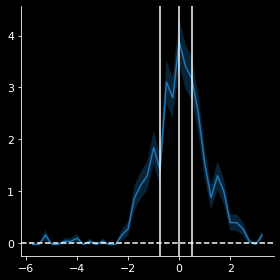

In [254]:
def plot_half_int(tuning_curve, SEM, spont_rate, frequencies, ax=None, **kwargs):

    half_int, widht_idx = half_integral(tuning_curve[None,:], frequencies)
    frequencies = zero_at_bf(tuning_curve[None,:], frequencies)[0,:]

    ax = plot_tuning_curve(tuning_curve, SEM, spont_rate, frequencies, ax=ax, logscale=False, **kwargs)

    max_idx = np.argmax(tuning_curve[:])
    left_idx, right_idx = widht_idx[0,:]

    ax.axvline(frequencies[max_idx])
    ax.axvline(frequencies[left_idx])
    ax.axvline(frequencies[right_idx])
    return ax
_ = plot_half_int(tuning_curves[best_neu_idx,:], SEMs[best_neu_idx,:], spont_rates[best_neu_idx], frequencies)


# load all sites with optotaging
#### db querry for parameter files

In [119]:
runclass='FTC'
sql="select sCellFile.*,gSingleCell.siteid,gSingleCell.phototag from gSingleCell INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid" +\
   " INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid" +\
   f" WHERE gRunClass.name='{runclass}' AND not(isnull(phototag))"
d=nd.pd_query(sql)
d['parmfile']=d['stimpath']+d['stimfile']

display(d)

,id,cellid,masterid,rawid,celldataid,runclassid,path,resplen,repcount,respfile,...,sortidx,model,stimsnr,area,goodtrials,respZ,respSNR,siteid,phototag,parmfile
0,146524,TNC017a-01-5,45717,144064,0,2,/auto/data/daq/Teonancatl/TNC017/sorted/,4751360,6,TNC017a21_p_FTC.spk.mat,...,1,0,1000,A1,,0.0,0.0,TNC017a,s,/auto/data/daq/Teonancatl/TNC017/TNC017a21_p_F...
1,146525,TNC017a-01-6,45717,144064,0,2,/auto/data/daq/Teonancatl/TNC017/sorted/,4751360,6,TNC017a21_p_FTC.spk.mat,...,1,0,1000,A1,,0.0,0.0,TNC017a,n,/auto/data/daq/Teonancatl/TNC017/TNC017a21_p_F...
2,146526,TNC017a-02-1,45717,144064,0,2,/auto/data/daq/Teonancatl/TNC017/sorted/,4751360,6,TNC017a21_p_FTC.spk.mat,...,1,0,1000,A1,,0.0,0.0,TNC017a,n,/auto/data/daq/Teonancatl/TNC017/TNC017a21_p_F...
3,146527,TNC017a-07-2,45717,144064,0,2,/auto/data/daq/Teonancatl/TNC017/sorted/,4751360,6,TNC017a21_p_FTC.spk.mat,...,1,0,1000,A1,,0.0,0.0,TNC017a,n,/auto/data/daq/Teonancatl/TNC017/TNC017a21_p_F...
4,146528,TNC017a-09-1,45717,144064,0,2,/auto/data/daq/Teonancatl/TNC017/sorted/,4751360,6,TNC017a21_p_FTC.spk.mat,...,1,0,1000,A1,,0.0,0.0,TNC017a,s,/auto/data/daq/Teonancatl/TNC017/TNC017a21_p_F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,148238,TNC019a-57-2,45731,144312,0,2,/auto/data/daq/Teonancatl/TNC019/sorted/,5543936,6,TNC019a20_p_FTC.spk.mat,...,1,0,1000,A1,,0.0,0.0,TNC019a,a,/auto/data/daq/Teonancatl/TNC019/TNC019a20_p_F...
392,148239,TNC019a-57-3,45731,144312,0,2,/auto/data/daq/Teonancatl/TNC019/sorted/,5543936,6,TNC019a20_p_FTC.spk.mat,...,1,0,1000,A1,,0.0,0.0,TNC019a,s,/auto/data/daq/Teonancatl/TNC019/TNC019a20_p_F...
393,148240,TNC019a-58-1,45731,144312,0,2,/auto/data/daq/Teonancatl/TNC019/sorted/,5543936,6,TNC019a20_p_FTC.spk.mat,...,1,0,1000,A1,,0.0,0.0,TNC019a,s,/auto/data/daq/Teonancatl/TNC019/TNC019a20_p_F...
394,148241,TNC019a-60-1,45731,144312,0,2,/auto/data/daq/Teonancatl/TNC019/sorted/,5543936,6,TNC019a20_p_FTC.spk.mat,...,1,0,1000,A1,,0.0,0.0,TNC019a,s,/auto/data/daq/Teonancatl/TNC019/TNC019a20_p_F...


#### select sites and parameter files, and parses optotagging values

In [120]:
site_df = d.loc[:, ['siteid', 'parmfile']].drop_duplicates()
tag_df = d.loc[:, ['cellid', 'phototag']].drop_duplicates()

activated = d.loc[d.phototag == 'a', 'cellid'].tolist()
supressed = d.loc[d.phototag == 's', 'cellid'].tolist()

#### loads recordins, gets tuning curves, organizes in big array

In [322]:
df_file = pl.Path(config['paths']['analysis_cache']) / '211020_ftc_summary_df'
recache = False
if df_file.exists() and recache == False:
    print(f'DF file found\nloading from {df_file}')
    DF = jl.load(df_file)
else:
    DF = pd.DataFrame()
    for _, row in site_df.iterrows():
        print(row.siteid)
        # print(row.parmfile)
        rec = get_rec(row.parmfile, rasterfs=1000)
        r, gcells = signal_reliability(rec['resp'], epoch_names=r'\ASTIM_\d*\Z', threshold=0.01)
        for normalization, smooth, part in itt.product([None, 'zscore', 'subdiv'], [None,1], ['all', 'onset', 'offset']):
            tc, sem, sr, fq = get_tuning_curves(rec, normalize=normalization, smooth=smooth, part=part)
            rel_fq = zero_at_bf(tc, fq)

            for func, fname in zip([full_width_half_max, half_integral], ['FWHM', 'half_int']):
                metric, widht_idx = func(tc, fq, spont_rates=sr)

                # perhaps sort the data in an array??
                df = pd.DataFrame()
                for cc, cellid in enumerate(rec['resp'].chans):
                    df['siteid'] = row.siteid
                    df['cellid'] = cellid
                    df['spont_rate'] = sr[cc]
                    df['response'] = tc[cc,:]
                    df['frequency'] = fq
                    df['sem'] = sem[cc,:]
                    df['reliability'] = r[cc]
                    df['metric_name'] = fname
                    df['metric_val'] = metric[cc]
                    df['left_edge'] = widht_idx[cc,0]
                    df['right_edge'] = widht_idx[cc,0]
                    df['normalization'] = str(normalization)
                    df['smooth'] = 0 if smooth == None else smooth
                    df['part'] = part

                    DF = DF.append(df, ignore_index=True)
    jl.dump(DF, df_file)
    print(f'donea, cacheing at {df_file}')

DF file found
loading from /home/mateo/code/context_probe_analysis/data/211020_ftc_summary_df


In [323]:
merge = pd.merge(DF, tag_df, how='inner', on='cellid', validate='m:1')
display(merge)

,siteid,cellid,spont_rate,response,frequency,sem,reliability,metric_name,metric_val,left_edge,right_edge,normalization,smooth,part,phototag
0,TNC017a,TNC017a-01-6,0.900901,15.000000,63,4.937731,0.028202,FWHM,0.75,1,1,None,0,all,n
1,TNC017a,TNC017a-01-6,0.900901,6.666667,75,3.305716,0.028202,FWHM,0.75,1,1,None,0,all,n
2,TNC017a,TNC017a-01-6,0.900901,11.666667,89,4.362032,0.028202,FWHM,0.75,1,1,None,0,all,n
3,TNC017a,TNC017a-01-6,0.900901,21.666667,106,5.914297,0.028202,FWHM,0.75,1,1,None,0,all,n
4,TNC017a,TNC017a-01-6,0.900901,10.000000,125,4.041860,0.028202,FWHM,0.75,1,1,None,0,all,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519475,TNC019a,TNC019a-64-1,0.000000,-0.395201,16000,0.000000,0.007000,half_int,3.25,3,3,subdiv,1,offset,s
519476,TNC019a,TNC019a-64-1,0.000000,-0.297887,19028,0.000000,0.007000,half_int,3.25,3,3,subdiv,1,offset,s
519477,TNC019a,TNC019a-64-1,0.000000,-0.179008,22628,0.247929,0.007000,half_int,3.25,3,3,subdiv,1,offset,s
519478,TNC019a,TNC019a-64-1,0.000000,-0.079273,26909,0.000000,0.007000,half_int,3.25,3,3,subdiv,1,offset,s


#### plots aligned tuning curves across all cells from all sites

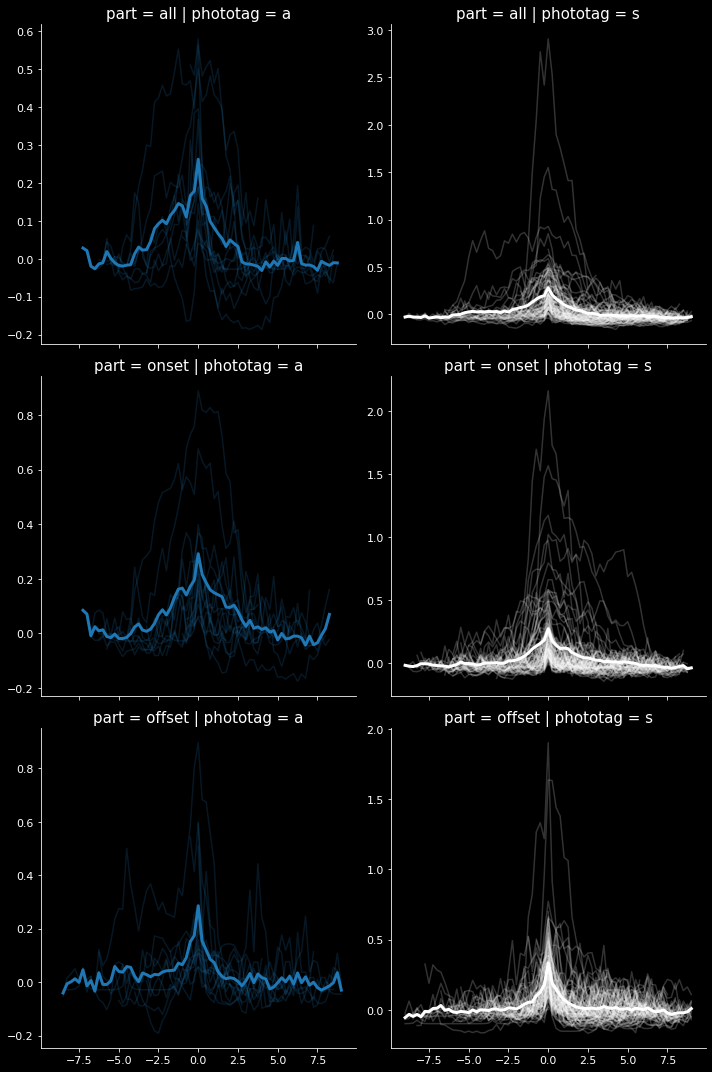

In [336]:
ff_reliable = merge.reliability > 0.01
ff_norm = merge.normalization == 'zscore'
ff_metric = merge.metric_name == 'FWHM'
ff_smooth = merge.smooth == 1
ff_part = merge.part.isin(['all', 'onset', 'offset'])

toplot = merge.loc[ff_reliable & ff_norm & ff_metric & ff_part,
                   ['cellid', 'response', 'frequency', 'phototag', 'part']]
def plot_aligned_curves(data, **kwargs):
    data = data.sort_values('frequency')
    frequency = data.frequency.unique()
    tuning_curves = data.pivot_table(columns='cellid', index='frequency', values='response').values
    centered_tuning_curves, common_rel_freqs = aling_at_bf(tuning_curves.T, frequency)

    ax = plt.gca()
    ax.plot(common_rel_freqs, centered_tuning_curves.T, color=kwargs['color'], alpha=0.2)
    ax.plot(common_rel_freqs, np.nanmean(centered_tuning_curves, axis=0),
            color=kwargs['color'], linewidth=3)
    return None

g = sns.FacetGrid(toplot, hue='phototag', palette=['C0', 'white'], hue_order=['a', 's'],
                  col='phototag', col_order=['a', 's'],
                  row='part', row_order=['all', 'onset', 'offset'],
                  sharex=True, sharey=False, height=5, aspect=1)
g.map_dataframe(plot_aligned_curves)


#### calculates full widht half max

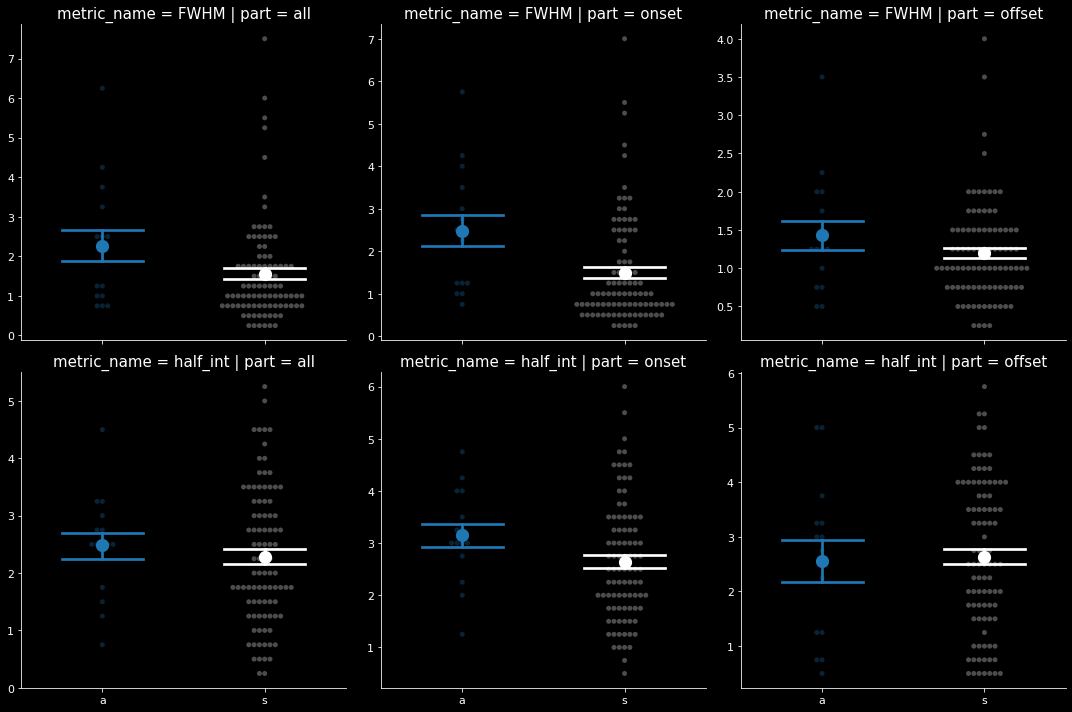

In [345]:
ff_reliable = merge.reliability > 0.01
ff_smooth = merge.smooth == 1
ff_norm = merge.normalization == 'zscore'
# display(merge.columns)
toplot = merge.loc[ff_reliable & ff_smooth & ff_norm,
                    ['cellid', 'reliability', 'metric_val', 'metric_name', 'phototag', 'part']].drop_duplicates()


# display(fwhm_df)
# sns.catplot(kind='point',x='phototag', y='metric_val', order =['a','s'],
#             col='part', row='metric_name',
#             ci=68,
#             data=toplot)


g = sns.FacetGrid(toplot, col='part', row='metric_name',
                  sharex=True, sharey=False, height=5, aspect=1)
g.map_dataframe(sns.pointplot, x='phototag', y='metric_val', order =['a','s'],
                hue='phototag', hue_order=['a','s'], palette=['C0', 'white'],
                capsize=0.5, scale=1.5, ci=68)
g.map_dataframe(sns.swarmplot, x='phototag', y='metric_val', order =['a','s'],
                hue='phototag', hue_order=['a','s'], palette=['C0', 'white'], alpha=0.3)




### compares metrics between different normalizations

normalization,cellid,metric_name,phototag,None,subdiv,zscore,diff
0,TNC014a-04-3,FWHM,s,1.75,1.75,1.75,0.0
536,TNC018a-32-1,FWHM,s,0.75,0.75,0.75,0.0
514,TNC018a-25-1,FWHM,n,3.00,3.00,3.00,0.0
515,TNC018a-25-1,half_int,n,3.00,3.00,3.00,0.0
516,TNC018a-27-1,FWHM,s,0.25,0.25,0.25,0.0
...,...,...,...,...,...,...,...
262,TNC016a-61-1,FWHM,n,1.00,1.00,1.00,0.0
263,TNC016a-61-1,half_int,n,0.50,0.50,0.50,0.0
264,TNC017a-01-6,FWHM,n,1.00,1.00,1.00,0.0
265,TNC017a-01-6,half_int,n,1.25,1.25,1.25,0.0


'TNC014a-04-3'

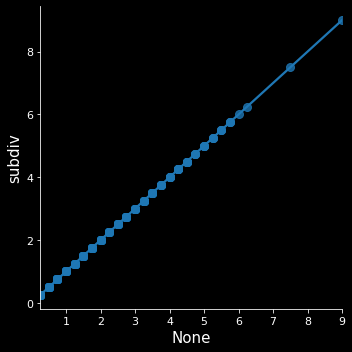

In [304]:
ff_smooth = merge.smooth == 1
ff_tag = merge.phototag.isin(['a', 's'])
ff_norm = merge.normalization.isin(['None', 'subdiv'])

norm_comparizon = merge.loc[ff_smooth, ['cellid', 'metric_name', 'metric_val', 'normalization', 'phototag']].drop_duplicates()
norm_comparizon = norm_comparizon.pivot_table(index=['cellid', 'metric_name', 'phototag'],
                                              columns='normalization', values='metric_val').reset_index()
norm_comparizon['diff'] =np.abs(norm_comparizon['None'].values - norm_comparizon['subdiv'].values)
norm_comparizon = norm_comparizon.sort_values('diff', ascending=[False])
display(norm_comparizon)
sns.lmplot(x='None' , y='subdiv', data=norm_comparizon)

badcell = norm_comparizon.iloc[0,0]
display(badcell)

(array([1.56]), array([[15, 28]]))

center sum: 2.1811882605545234 full half: 2.112508516331654


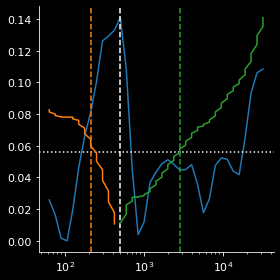

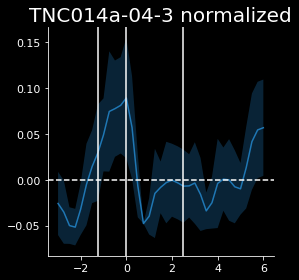

In [300]:
# badcell = 'TNC014a-27-1'
ff_neuron = merge.cellid == badcell
ff_smooth = merge.smooth == 1
ff_norm = merge.normalization == 'zscore'

toplot = merge.loc[ff_neuron & ff_norm & ff_smooth, :].sort_values(['frequency'])
display(full_width_half_max(toplot['response'].values[None,:], toplot['frequency'].values, toplot['spont_rate'].values))

_  = half_integral(toplot['response'].values[None,:], toplot['frequency'].values, db_plot=True)
ax = plot_half_int(toplot['response'].values, toplot['sem'].values,  toplot['spont_rate'].values[0], toplot['frequency'].values)
_ = ax.set_title(f'{badcell} normalized')

(array([0.36]), array([[17, 20]]))

center sum: 233.33333333333334 full half: 273.3333333333333


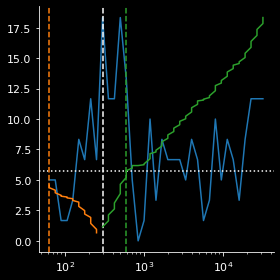

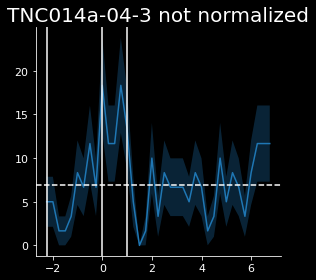

In [313]:
ff_norm = merge.normalization == 'None'
ff_smooth =merge.smooth == 1

toplot = merge.loc[ff_neuron & ff_norm & ff_smooth, ['response', 'spont_rate', 'sem', 'frequency']].sort_values(['frequency'])
display(full_width_half_max(toplot['response'].values[None,:], toplot['frequency'].values, toplot['spont_rate'].values))

_  = half_integral(toplot['response'].values[None,:], toplot['frequency'].values, db_plot=True)
ax = plot_half_int(toplot['response'].values, toplot['sem'].values,  toplot['spont_rate'].values[0], toplot['frequency'].values)
_ = ax.set_title(f'{badcell} not normalized')

### what about negative tuning curves??

In [312]:
ff_norm = merge.normalization == 'zscore'

responses = merge.loc[ff_norm, ['cellid', 'frequency', 'response']].drop_duplicates().sort_values('response')
display(responses)


,cellid,frequency,response
138261,TNC019a-04-1,9514,-0.197353
72975,TNC016a-43-4,421,-0.194912
138258,TNC019a-04-1,5657,-0.188911
138263,TNC019a-04-1,13455,-0.188911
138256,TNC019a-04-1,4000,-0.188911
...,...,...,...
128118,TNC018a-42-3,4000,3.373419
128044,TNC018a-42-3,4000,3.406647
128117,TNC018a-42-3,3364,3.410596
133381,TNC018a-51-1,19028,3.678153


(array([1.08]), array([[ 3, 12]]))

center sum: 3.41182479619404 full half: 3.55029517921626


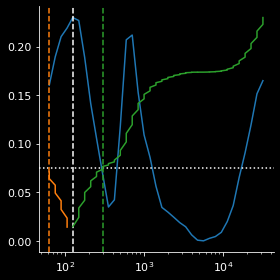

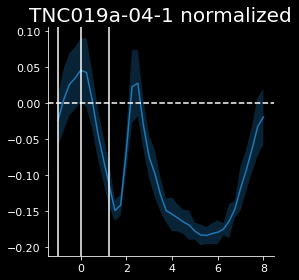

In [314]:
badcell = 'TNC019a-04-1'
ff_neuron = merge.cellid == badcell
ff_smooth = merge.smooth == 1
ff_norm = merge.normalization == 'zscore'

toplot = merge.loc[ff_neuron & ff_norm & ff_smooth, :].sort_values(['frequency'])
display(full_width_half_max(toplot['response'].values[None,:], toplot['frequency'].values, toplot['spont_rate'].values))

_  = half_integral(toplot['response'].values[None,:], toplot['frequency'].values, db_plot=True)
ax = plot_half_int(toplot['response'].values, toplot['sem'].values,  toplot['spont_rate'].values[0], toplot['frequency'].values)
_ = ax.set_title(f'{badcell} normalized')
